# ENSAE Master Spécialisé Data Science - Projet Python de 1er semestre

*Par Alexandre Combessie et Thibaut Duguet*

## Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [3]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO
import nltk
import sklearn

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [4]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [6]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [5]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

In [12]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0006428320,"[0, 0]",3,The portfolio is fine except for the fact that...,"03 11, 2014",A1YS9MDZP93857,John Taylor,Parts missing,1394496000
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800
3,0041913574,"[0, 0]",5,Perfect for someone who is an opera fan or a w...,"09 23, 2010",A19K10Z0D2NTZK,TexasCowboy,Full score: voice and orchestra,1285200000
4,0201891859,"[0, 1]",1,How many Nocturnes does it contain? All of the...,"10 17, 2012",A14X336IB4JD89,dfjm53,Unable to determine contents,1350432000


## Séparation Training and Validation sets

Avant de commencer toute analyse ou modélisation, il faut séparer l'échantillon d'entrainement et l'échantillon de validation. On procède comme suit:

In [6]:
from sklearn.cross_validation import train_test_split
y = df["overall"]
X = df.drop("overall",axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
df_train=pd.concat([X,y],axis=1).iloc[X_train] # return dataframe train
df_test=pd.concat([X,y],axis=1).iloc[X_test] # return dataframe test
print(df_train.shape, df_test.shape)

(400146, 9) (100037, 9)


## Analyse descriptive

Regardons la structure de la table:

In [10]:
df_train.head()

,asin,helpful,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,overall
466007,B002VUCB6S,"[0, 0]",We love the car seat! We think that it was an ...,"07 3, 2011",A36AP2W6NHIE22,Dragon,purple,1309651200,5
44028,B00007DWDZ,"[0, 0]",I went through three of these pumps with my la...,"01 30, 2009",A1N07L9HY2Y6LE,Adrienne K. Weighall,"If you need to pump on a regular basis, don't ...",1233273600,2
859001,B00BEVF1VC,"[0, 0]",I bought this seat for a tall slender 3 yr old...,"04 11, 2014",A3AQNBL36B8WGQ,Janine H,Great all around seat ~ worth the $$$,1397174400,5
548494,B003SWZVG0,"[1, 1]",I first used this bottle brush for my eldest s...,"01 23, 2012",AS3JX5GLRYISL,Ardencie,Pretty darn good,1327276800,4
258952,B000YDDF6O,"[0, 0]","i was pleased with this item, wasy grip and i...","01 14, 2013",A30ZR1R8AUB5EG,NaN,baby toy,1358121600,4


Etudions les dimensions clés de la table:

In [11]:
Nbreviews=len(df_train)
Nbproducts=len(set(df_train["asin"]))
Nbreviewers=len(set(df_train["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 732358
Le nombre total de produits est: 59337
Le nombre total de reviewers est: 451833
Soit un nombre moyen de 12.3 reviews par produit
Soit un nombre moyen de 1.6 reviews par reviewers


Analysons la distribution des notes des reviews

count    732358.00
mean          4.12
std           1.29
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           5.00
Name: overall, dtype: float64


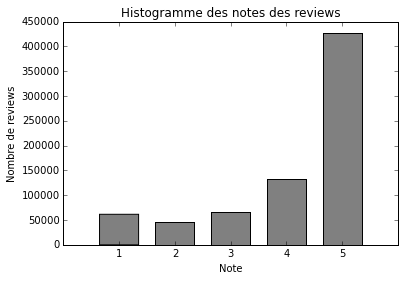

In [12]:
print(df_train["overall"].describe().round(2))
%matplotlib inline 
a=[int(i) for i in df_train["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Nombre de reviews");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

count    59337.00
mean         4.06
std          1.04
min          1.00
25%          3.56
50%          4.33
75%          5.00
max          5.00
Name: overall, dtype: float64


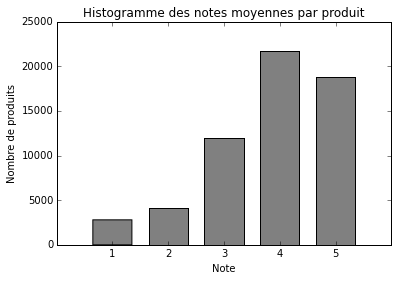

In [13]:
average_note_byproduct=df_train[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct["overall"].describe().round(2))
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Nombre de produits");

Regardons la distribution du nombre de reviews par utilisateur.

count    451833.00
mean          1.62
std           1.85
min           1.00
25%           1.00
50%           1.00
75%           2.00
max         129.00
dtype: float64


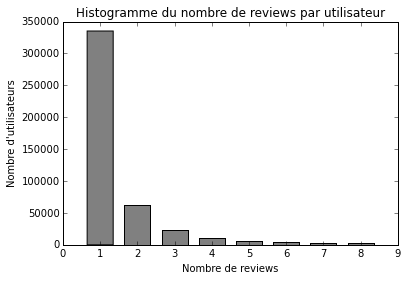

In [14]:
import collections
Nbreview_by_user=collections.Counter(df_train["reviewerID"])
print(pd.Series(Nbreview_by_user).describe().round(2))
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("Nombre d'utilisateurs");

Définissons la fonction de comptage du nombre de mots d'une review et appliquons la à nos données

In [13]:
def countWords(review):
    return(len(review.split()))

In [14]:
df_train["countWordsReview"] = df_train["reviewText"].apply(countWords)
df_test["countWordsReview"] = df_test["reviewText"].apply(countWords)
df_train["countWordsSummary"] = df_train["summary"].apply(countWords)
df_test["countWordsSummary"] = df_test["summary"].apply(countWords)

Regardons la distribution du nombre de mots des reviews

In [17]:
print(df_train["countWordsReview"].describe().round(2))

count    732358.00
mean         81.87
std          87.11
min           0.00
25%          31.00
50%          55.00
75%         100.00
max        4546.00
Name: countWordsReview, dtype: float64


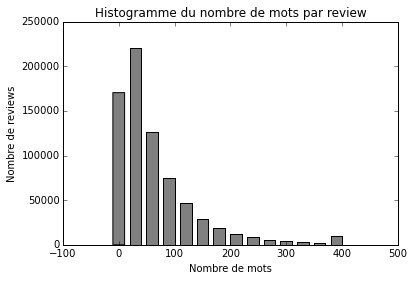

In [18]:
%matplotlib inline 
bins=range(0,430,30)
a = np.clip(df_train["countWordsReview"], 0, 400)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

Maintenant regardons plus spécifiquement entre 0 et 100 mots

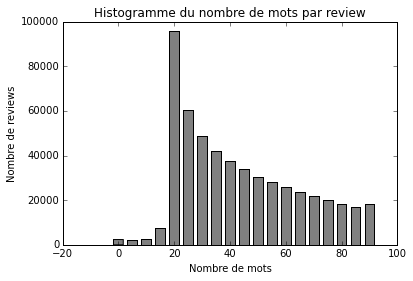

In [19]:
a = [s for s in df_train["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

## Préparation des données

On prépare les données de texte en utilisant la fonction `TfidfVectorizer` du package `sklearn`. Notons que nous utilisons les stopwords donnés par `nltk` pour réduire le nombre de mots.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
tfidf_vect = TfidfVectorizer()
tfidf_vect_stopword = TfidfVectorizer(stop_words= stopwords.words('english'))

### 1. Texte complet de la review

#### a. Echantillon Train

In [16]:
corpus_train_reviewText=list(df_train["reviewText"])
X_train_tfidf_reviewText = tfidf_vect_stopword.fit_transform(corpus_train_reviewText)
X_train_tfidf_reviewText.shape

(400146, 219182)

#### b. Echantillon Test

In [17]:
corpus_test_reviewText=list(df_test["reviewText"])
X_test_tfidf_reviewText = tfidf_vect_stopword.transform(corpus_test_reviewText)
X_test_tfidf_reviewText.shape

(100037, 219182)

### 2. Texte du résumé de la review

#### a. Echantillon Train

In [18]:
corpus_train_summary=list(df_train["summary"])
X_train_tfidf_summary = tfidf_vect_stopword.fit_transform(corpus_train_summary)
X_train_tfidf_summary.shape

(400146, 41874)

#### b. Echantillon Test

In [19]:
corpus_test_summary=list(df_test["summary"])
X_test_tfidf_summary = tfidf_vect_stopword.transform(corpus_test_summary)
X_test_tfidf_summary.shape

(100037, 41874)

### 3. Features supplémentaires

Nous allons créer des variables pour le mois et le jour de la review, ce qui peut influencer la note.

In [20]:
from datetime import datetime
df_train["Weekday"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_test["Weekday"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_train["Weekday"].head()

10056     Mon
56463     Mon
274241    Thu
269301    Tue
396082    Fri
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [21]:
df_train["Month"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_test["Month"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_train["Month"].head()

10056     03
56463     11
274241    07
269301    09
396082    04
Name: Month, dtype: category
Categories (12, object): [01, 02, 03, 04, ..., 09, 10, 11, 12]

In [22]:
from sklearn.feature_extraction import DictVectorizer
dic_vec = DictVectorizer()

#### a. Echantillon Train

In [23]:
X_train_countWords=df_train[["countWordsReview","countWordsSummary"]].astype(int)
X_train_dates=df_train[["Month","Weekday"]]
X_train_otherfeatures=df_train[["countWordsReview","countWordsSummary","Month","Weekday"]]
print(X_train_countWords.shape, X_train_dates.shape, X_train_otherfeatures.shape)

(400146, 2) (400146, 2) (400146, 4)


In [24]:
dic_train_weekdays = pd.DataFrame(X_train_otherfeatures["Weekday"]).to_dict('records')
X_train_weekdays = dic_vec.fit_transform(dic_train_weekdays)
X_train_weekdays.shape

(400146, 7)

In [25]:
dic_train_months = pd.DataFrame(X_train_otherfeatures["Month"]).to_dict('records')
X_train_months = dic_vec.fit_transform(dic_train_months)
X_train_months.shape

(400146, 12)

#### b. Echantillon Test

In [26]:
X_test_countWords=df_test[["countWordsReview","countWordsSummary"]].astype(int)
X_test_dates=df_test[["Month","Weekday"]]
X_test_otherfeatures=df_test[["countWordsReview","countWordsSummary","Month","Weekday"]]
print(X_test_countWords.shape, X_test_dates.shape, X_test_otherfeatures.shape)

(100037, 2) (100037, 2) (100037, 4)


In [27]:
dic_test_weekdays = pd.DataFrame(X_test_otherfeatures["Weekday"]).to_dict('records')
X_test_weekdays = dic_vec.fit_transform(dic_test_weekdays)
X_test_weekdays.shape

(100037, 7)

In [28]:
dic_test_months = pd.DataFrame(X_test_otherfeatures["Month"]).to_dict('records')
X_test_months = dic_vec.fit_transform(dic_test_months)
X_test_months.shape

(100037, 12)

### 4. Combinaison de toutes les features

#### a. Echantillon Train

In [29]:
from scipy.sparse import hstack
X_train_alltext=hstack([X_train_tfidf_reviewText, X_train_tfidf_summary])
print(X_train_alltext.shape)

(400146, 261056)


In [30]:
X_train_textwordcount=hstack([X_train_alltext,X_train_countWords.astype(int)])
X_train_textwordcount.shape

(400146, 261058)

In [31]:
X_train_allfeatures = hstack([X_train_textwordcount, X_train_weekdays, X_train_months])
print(X_train_allfeatures.shape)

(400146, 261077)


In [33]:
X_train_supfeatures = hstack([X_train_countWords.astype(int), X_train_weekdays, X_train_months])
print(X_train_supfeatures.shape)

(400146, 21)


#### b. Echantillon Test

In [34]:
X_test_alltext=hstack([X_test_tfidf_reviewText, X_test_tfidf_summary])
print(X_test_alltext.shape)

(100037, 261056)


In [35]:
X_test_textwordcount=hstack([X_test_alltext,X_test_countWords.astype(int)])
X_test_textwordcount.shape

(100037, 261058)

In [36]:
X_test_allfeatures = hstack([X_test_textwordcount, X_test_weekdays, X_test_months])
print(X_test_allfeatures.shape)

(100037, 261077)


In [37]:
X_test_supfeatures = hstack([X_test_countWords.astype(int), X_test_weekdays, X_test_months])
print(X_test_supfeatures.shape)

(100037, 21)


## Machine Learning

En utilisant la librairie `sklearn`, nous allons appliquer les modèles suivants:
- Naive Bayes, 
- Support Vector Machines avec Stochastic Gradient Descent, 
- k-Nearest Neighbors. 

Nous avons essayé des Random Forests mais les calculs n'ont jamais pu aboutir, compte tenu du grand nombre de dimensions.

### 1. Texte complet de la review

In [60]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_NaiveBayes_reviewText = clf.predict(X_test_tfidf_reviewText)

In [61]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_SVM_reviewText = clf2.predict(X_test_tfidf_reviewText)

### 2. Texte du résumé de la review

In [47]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_NaiveBayes_summary = clf.predict(X_test_tfidf_summary)

In [48]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_SVM_summary = clf2.predict(X_test_tfidf_summary)

### 3. Texte complet et résumé de la review

In [49]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_alltext, y_train.astype('category'))
predicted_NaiveBayes_alltext = clf.predict(X_test_alltext)

In [50]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_alltext, y_train.astype('category'))
predicted_SVM_alltext = clf2.predict(X_test_alltext)

### 4. Features supplémentaires

In [51]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_supfeatures, y_train.astype('category'))
predicted_NaiveBayes_supfeatures = clf.predict(X_test_supfeatures)

In [52]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_supfeatures, y_train.astype('category'))
predicted_SVM_supfeatures = clf2.predict(X_test_supfeatures)

### 5. Combinaison de toutes les features

In [89]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_allfeatures, y_train.astype('category'))
predicted_NaiveBayes_allfeatures = clf.predict(X_test_allfeatures)

In [88]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_allfeatures, y_train.astype('category'))
predicted_SVM_allfeatures = clf2.predict(X_test_allfeatures)

# Evaluation de la performance

### 1. Pour le texte complet de la review

In [70]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_reviewText == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_reviewText == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 61.9%
L'accuracy du classifieur SVM est de 61.9%


In [71]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_reviewText))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_reviewText))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.92      0.01      0.02      6989
        2.0       0.00      0.00      0.00      4542
        3.0       0.00      0.00      0.00      7827
        4.0       0.57      0.00      0.00     18825
        5.0       0.62      1.00      0.76     61854

avg / total       0.55      0.62      0.47    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.80      0.00      0.01      6989
        2.0       0.00      0.00      0.00      4542
        3.0       0.00      0.00      0.00      7827
        4.0       0.00      0.00      0.00     18825
        5.0       0.62      1.00      0.76     61854

avg / total       0.44      0.62      0.47    100037



D:\Users\acombess\PythonENSAE\python\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_reviewText))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_reviewText))

Matrice de confusion du classifieur Naive Bayes 
 [[   67     0     0     1  6921]
 [    3     0     0     1  4538]
 [    0     1     0     0  7826]
 [    1     0     1     8 18815]
 [    2     0     0     4 61848]]
Matrice de confusion du classifieur SVM 
 [[   20     0     0     0  6969]
 [    3     0     0     0  4539]
 [    2     0     0     0  7825]
 [    0     0     0     0 18825]
 [    0     0     0     0 61854]]


### 2. Pour le résumé de la review

In [73]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_summary == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_summary == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 66.0%
L'accuracy du classifieur SVM est de 62.9%


In [75]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_summary))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_summary))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.66      0.40      0.49      6989
        2.0       0.30      0.00      0.01      4542
        3.0       0.51      0.11      0.18      7827
        4.0       0.40      0.08      0.13     18825
        5.0       0.67      0.99      0.80     61854

avg / total       0.59      0.66      0.57    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.67      0.08      0.14      6989
        2.0       0.10      0.00      0.00      4542
        3.0       0.66      0.06      0.11      7827
        4.0       0.56      0.01      0.01     18825
        5.0       0.63      1.00      0.77     61854

avg / total       0.60      0.63      0.50    100037



In [76]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_summary))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_summary))

Matrice de confusion du classifieur Naive Bayes 
 [[ 2761    20   161   266  3781]
 [  822    18   347   334  3021]
 [  341    15   863   940  5668]
 [  112     3   238  1413 17059]
 [  135     5    88   613 61013]]
Matrice de confusion du classifieur SVM 
 [[  567     0     8     4  6410]
 [   99     1    78     6  4358]
 [   67     6   488    55  7211]
 [   84     2   137   124 18478]
 [   29     1    31    31 61762]]


### 3. Texte complet et résumé de la review

In [78]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_alltext == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_alltext == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 64.5%
L'accuracy du classifieur SVM est de 64.1%


In [80]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_alltext))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_alltext))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.81      0.28      0.42      6989
        2.0       0.00      0.00      0.00      4542
        3.0       0.58      0.02      0.05      7827
        4.0       0.33      0.04      0.07     18825
        5.0       0.65      1.00      0.79     61854

avg / total       0.56      0.65      0.53    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.73      0.21      0.33      6989
        2.0       0.19      0.00      0.00      4542
        3.0       0.65      0.08      0.14      7827
        4.0       0.54      0.02      0.03     18825
        5.0       0.64      1.00      0.78     61854

avg / total       0.61      0.64      0.52    100037



In [81]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_alltext))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_alltext))

Matrice de confusion du classifieur Naive Bayes 
 [[ 1962     0    13   205  4809]
 [  334     0    81   323  3804]
 [  101     1   191   843  6691]
 [   15     0    35   735 18040]
 [   17     1    10   145 61681]]
Matrice de confusion du classifieur SVM 
 [[ 1471     3    18    25  5472]
 [  332     4   104    35  4067]
 [  135    13   617   140  6922]
 [   56     1   171   323 18274]
 [   29     0    36    74 61715]]


### 4. Features supplémentaires

In [83]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_supfeatures == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_supfeatures == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 59.5%
L'accuracy du classifieur SVM est de 61.8%


In [85]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_supfeatures))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_supfeatures))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      6989
        2.0       0.00      0.00      0.00      4542
        3.0       0.00      0.00      0.00      7827
        4.0       0.24      0.09      0.14     18825
        5.0       0.62      0.93      0.75     61854

avg / total       0.43      0.59      0.49    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      6989
        2.0       0.00      0.00      0.00      4542
        3.0       0.00      0.00      0.00      7827
        4.0       0.00      0.00      0.00     18825
        5.0       0.62      1.00      0.76     61854

avg / total       0.38      0.62      0.47    100037



D:\Users\acombess\PythonENSAE\python\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_supfeatures))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_supfeatures))

Matrice de confusion du classifieur Naive Bayes 
 [[    0     0     0   369  6620]
 [    0     0     0   377  4165]
 [    0     0     0   708  7119]
 [    1     0     0  1788 17036]
 [    0     0     0  4139 57715]]
Matrice de confusion du classifieur SVM 
 [[    0     0     0     0  6989]
 [    0     0     0     0  4542]
 [    0     0     0     0  7827]
 [    0     0     0     0 18825]
 [    0     0     0     0 61854]]


### 3. Pour la combinaison des features

In [90]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_allfeatures == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_allfeatures == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 63.8%
L'accuracy du classifieur SVM est de 61.8%


In [91]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_allfeatures))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_allfeatures))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.78      0.20      0.32      6989
        2.0       0.00      0.00      0.00      4542
        3.0       0.58      0.02      0.05      7827
        4.0       0.29      0.03      0.05     18825
        5.0       0.64      1.00      0.78     61854

avg / total       0.55      0.64      0.52    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       1.00      0.00      0.00      6989
        2.0       0.00      0.00      0.00      4542
        3.0       0.40      0.00      0.00      7827
        4.0       0.73      0.00      0.00     18825
        5.0       0.62      1.00      0.76     61854

avg / total       0.62      0.62      0.47    100037



D:\Users\acombess\PythonENSAE\python\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [93]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_allfeatures))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_allfeatures))

Matrice de confusion du classifieur Naive Bayes 
 [[ 1425     0     9   227  5328]
 [  246     0    74   271  3951]
 [   92     0   195   645  6895]
 [   23     0    50   508 18244]
 [   30     0    10    85 61729]]
Matrice de confusion du classifieur SVM 
 [[    1     0     0     0  6988]
 [    0     0     2     0  4540]
 [    0     0     2     0  7825]
 [    0     0     1     8 18816]
 [    0     0     0     3 61851]]


## Simplification du problème en classification binaire

In [ ]:
#X_train_bin
#X_test_bin=

## Analyse de la performance en fonction du nombre de mots

In [ ]:
def createBins(x):
    if x["countWordsReview"] < 30:
        return(30)
    elif x["countWordsReview"] < 100:
        return(100)
    elif x["countWordsReview"] < 200:
        return(200)
    else:
        return(300)

In [ ]:
dfy = pd.DataFrame(y_test)
dfy["predicted"] = predicted_reviewText
dfy["reviewText"] = df_test["reviewText"]
dfy["countWordsReview"] = dfy["reviewText"].apply(countWords)
dfy["summary"] = df_test["summary"]
dfy["countWordsSummary"] = dfy["summary"].apply(countWords)
dfy["qualite"] = abs(predicted_reviewText - y_test)
dfy["bin"] = dfy.apply(createBins, axis = 1)
dfy.head()

In [ ]:
np.mean(dfy[dfy.bin==30]["qualite"])

In [ ]:
sum(abs(predicted_reviewText - y_test))

## Bits of useless code (so far)

In [ ]:
#an example with another function TfidfVectorizer using frequency instead of count
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ["This is very strange",
          "This is very nice"]
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
print(dict(zip(vectorizer.get_feature_names(), idf)))

In [ ]:
# A possible approach that would require to construct pipelines
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import HashingVectorizer
hash_vect = HashingVectorizer()

In [ ]:
for i in range(0,5) :
        print(str(corpus_test_reviewText[i]) +"\n"+ "------ We predict "+ str(predicted_reviewText[i])+"\n")

Then: draw multi class ROC Curve using this example: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

# Todo

- Evaluation de la performance pour les différents blocs de features
- Normalisation du nombre de mots
- Classification binaire + courbe de ROC
- Analyse de la performance en fonction du nombre de mots